In [1]:
!pip install tslearn

     |████████████████████████████████| 798kB 5.3MB/s 


In [2]:
!pip install sktime

     |████████████████████████████████| 5.7MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 39.9MB/s 
     |████████████████████████████████| 22.3MB 1.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Converting date to datetime, comma seperated strings to float, extraction date features as feature extraction and for exploratory analysis, subtracting ptf from smf as it is an important indicator

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sktime.distances.elastic_cython import dtw_distance
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
df = pd.read_excel('nisan_ptf_smf_netYon.xlsx', index_col=0)
df['instrument'] = pd.to_datetime(df['instrument'])
df['ptf'] = df['ptf'].str.replace(',','.').astype(float)
df['smf'] = df['smf'].str.replace(',','.').astype(float)
df.columns = ['time','ptf','smf','netYon']
##
df["day"] = df["time"].dt.day
df["hour"] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['smf_ptf_diff'] = df['smf'] - df['ptf']

In [ ]:
df

,time,ptf,smf,netYon,day,hour,dayofweek,smf_ptf_diff
0,2021-04-01 00:00:00,234.43,263.43,304.476,1,0,3,29.00
1,2021-04-01 01:00:00,310.02,344.02,942.555,1,1,3,34.00
2,2021-04-01 02:00:00,256.99,285.99,533.836,1,2,3,29.00
3,2021-04-01 03:00:00,238.88,267.88,296.610,1,3,3,29.00
4,2021-04-01 04:00:00,234.87,259.80,251.892,1,4,3,24.93
...,...,...,...,...,...,...,...,...
715,2021-04-30 19:00:00,376.71,376.71,0.000,30,19,4,0.00
716,2021-04-30 20:00:00,372.17,357.00,-255.794,30,20,4,-15.17
717,2021-04-30 21:00:00,369.02,370.00,192.371,30,21,4,0.98
718,2021-04-30 22:00:00,358.42,399.00,650.304,30,22,4,40.58


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff93d5762d0>,
      dtype=object)

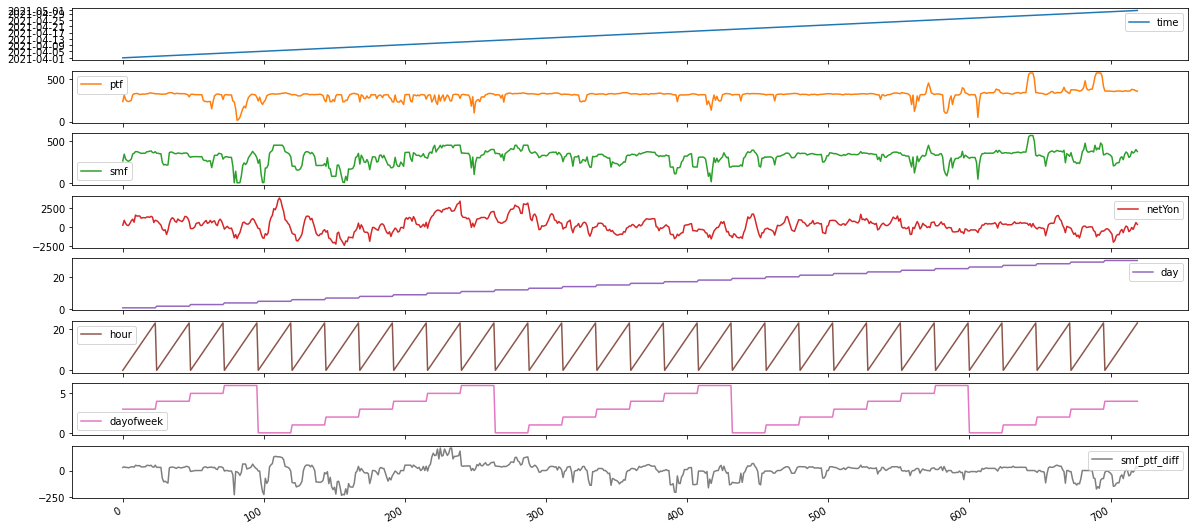

In [ ]:
df.plot(subplots=True, figsize=(20,10))

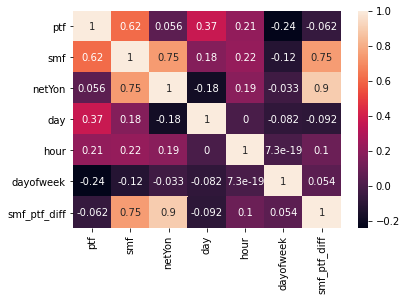

In [ ]:
sns.heatmap(df.drop('time',1).corr(),annot=True)

<Figure size 864x576 with 0 Axes>

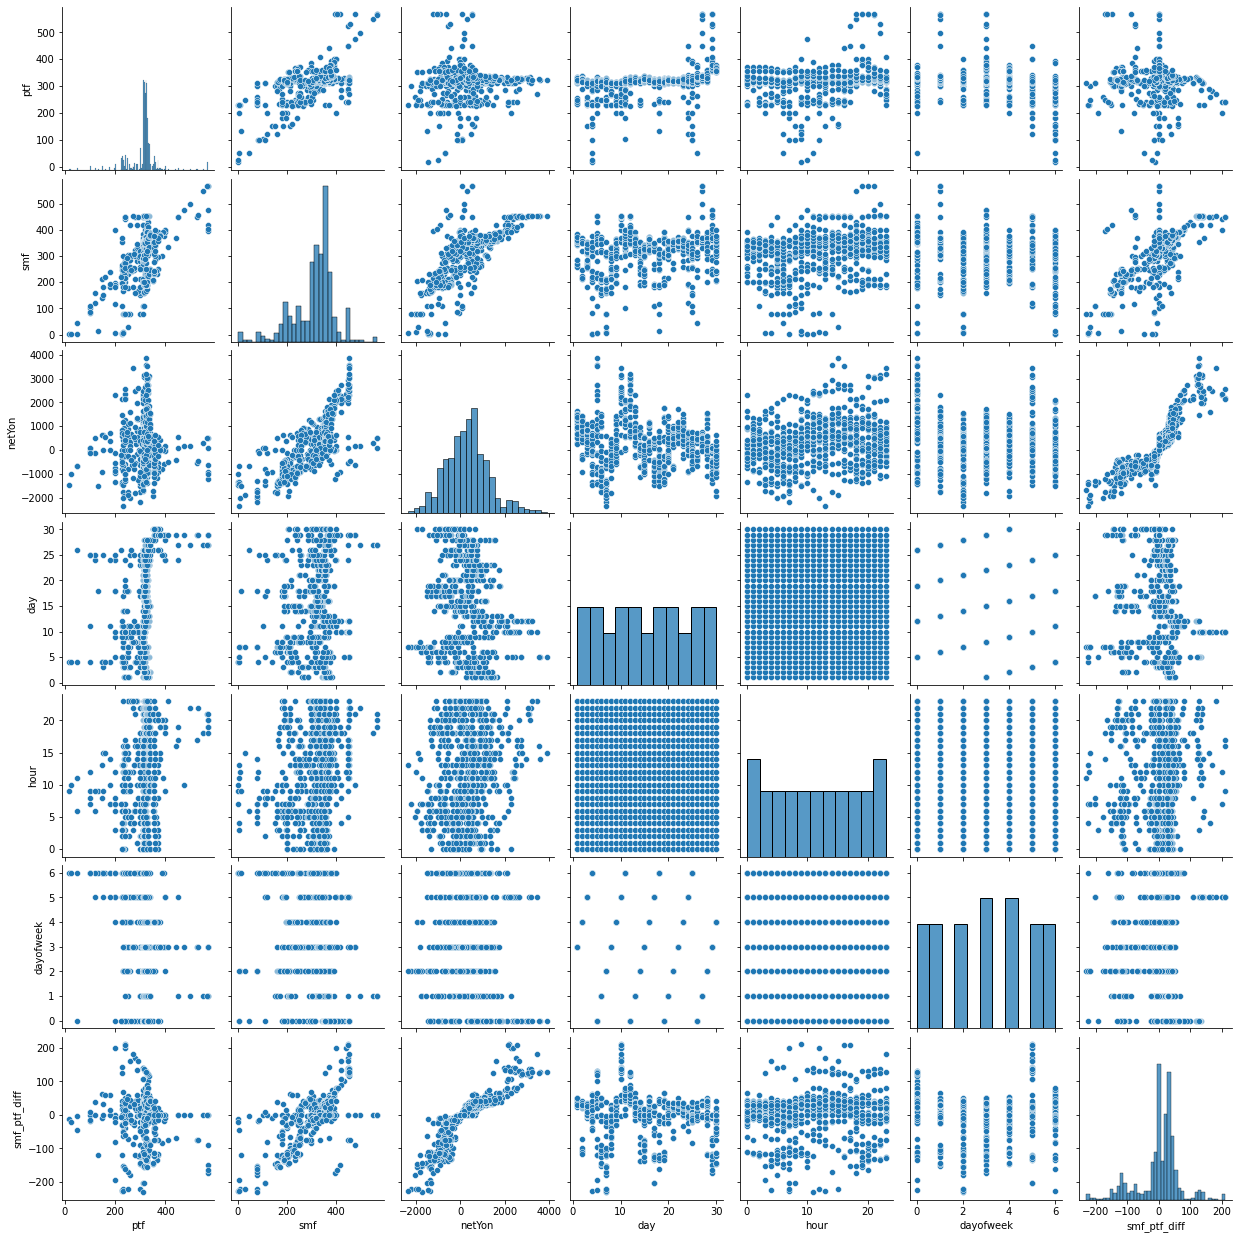

In [ ]:
plt.figure(figsize=(12,8))
sns.pairplot(df.drop(['time'],1))

#Positively correlated linear relation between ptf and smf (0.62)

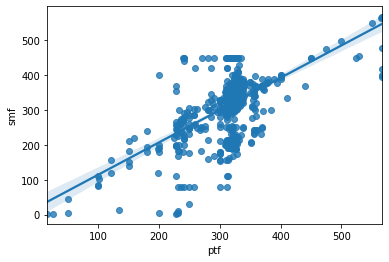

In [ ]:
sns.regplot(x=df['ptf'],y=df['smf'])

#Positively correlated strong linear relation between ptf-smf and netYon (0.9) as expected from its definition

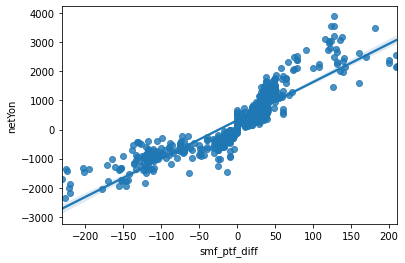

In [ ]:
sns.regplot(x=df['smf_ptf_diff'],y=df['netYon'])

# Ptf complies strictly to a daily upper bound of approximately 400 up till 16:00, a less strict lower bound of 200 can also be mentioned which creates a rectangular pattern

Electrical demand increases through night-time and is low during day-time so the non-rectangular data is scattered with low values in the beginning of the day and high values through the end.

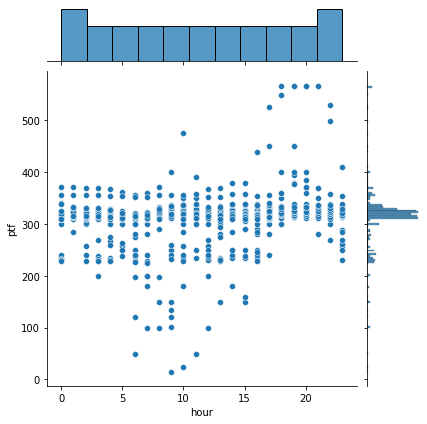

In [ ]:
sns.jointplot(x=df['hour'],y=df['ptf'])

# Similar rectangular behavior is also observed monthly expanding only on the end of the month, mentioned patterns exist in smf as well 

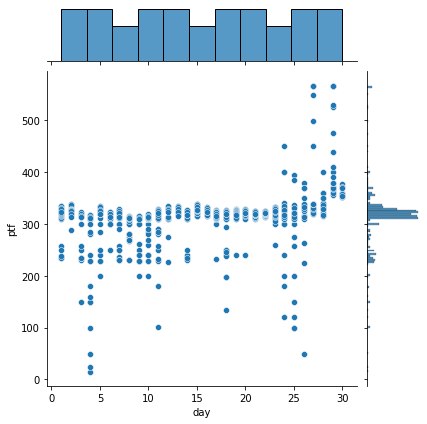

In [ ]:
sns.jointplot(x=df['day'],y=df['ptf'])

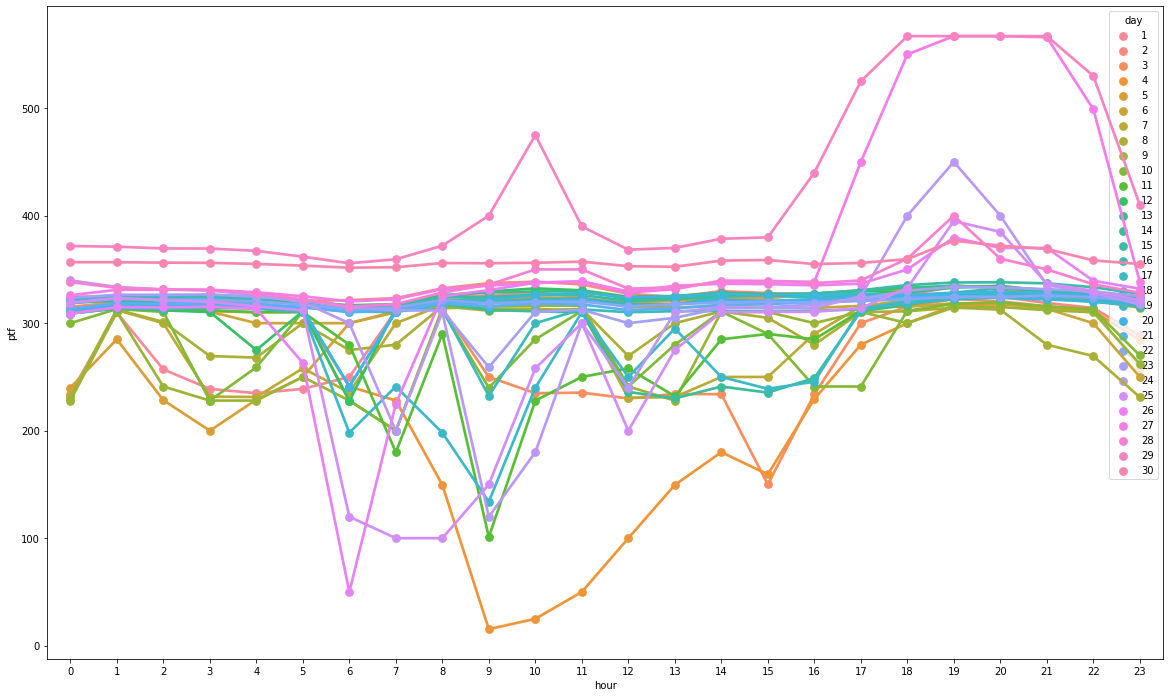

In [ ]:
plt.figure(figsize=(20,12))
sns.pointplot(data=df, x='hour', y='ptf',hue='day')

SMF series' are more scattered overall

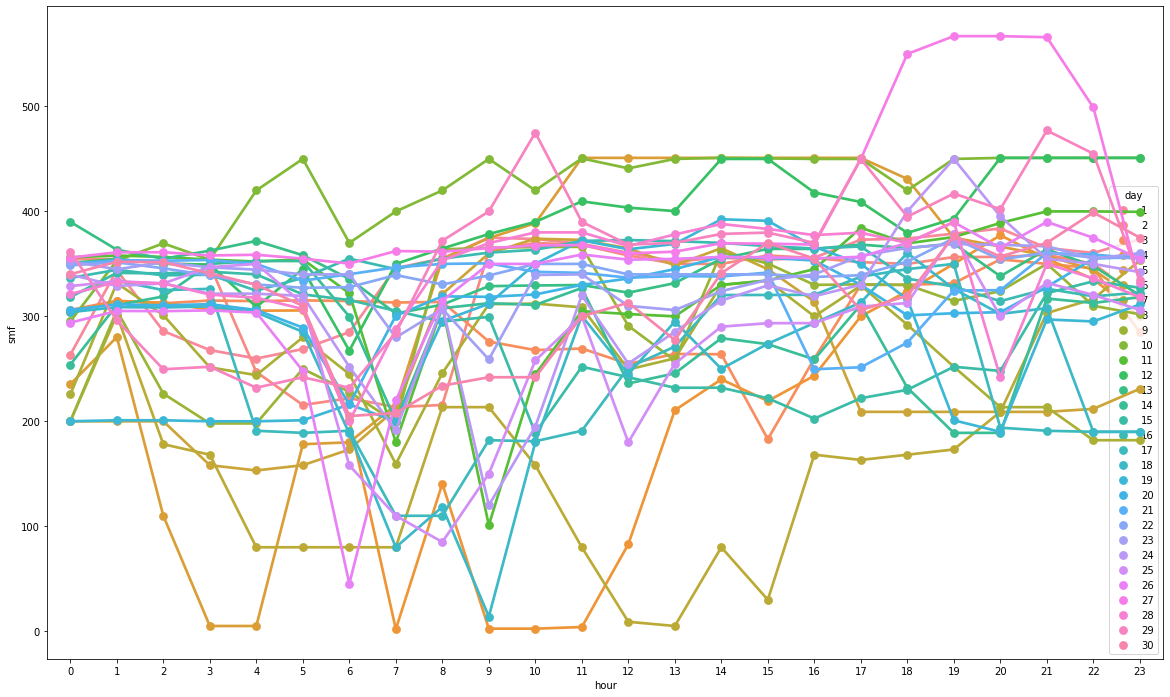

In [ ]:
plt.figure(figsize=(20,12))
sns.pointplot(data=df, x='hour', y='smf',hue='day')

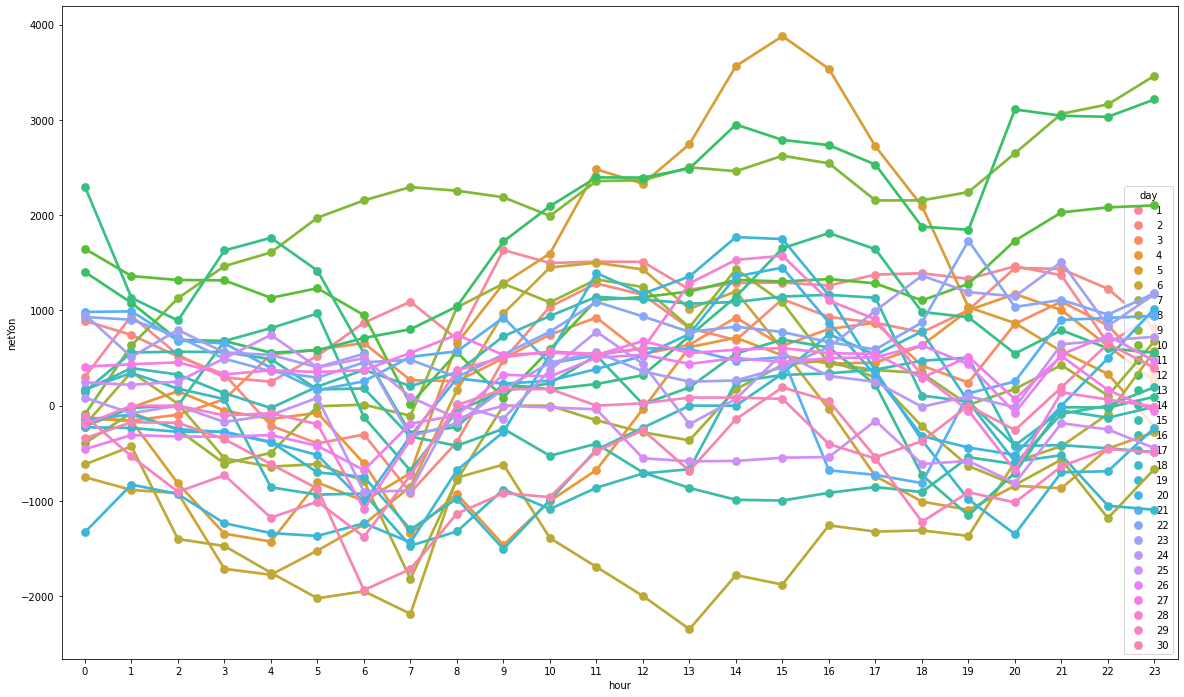

In [ ]:
plt.figure(figsize=(20,12))
sns.pointplot(data=df, x='hour', y='netYon',hue='day')

# These time-series are quite similar to my eye, I would not expect more than 4 clusters as an initial intuition

## Reduce the data with pca to visualize the distribution. 3 Components explain 0.9 variance which is adequate for visualization

Text(0, 0.5, 'cumulative explained variance')

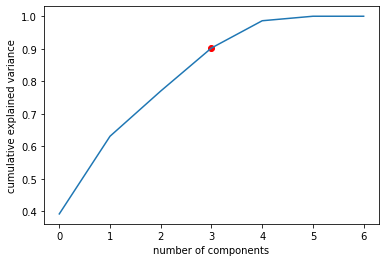

In [10]:
df_scaled = StandardScaler().fit_transform(df.drop('time',1))
pca = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(3,np.cumsum(pca.explained_variance_ratio_)[3], color = 'red')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [11]:
df_pca = PCA(n_components=3).fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['pc1','pc2','pc3'])

#High spherical density in the center is observed

In [ ]:
fig = px.scatter_3d(df_pca, x='pc1', y='pc2', z='pc3')
fig.show()

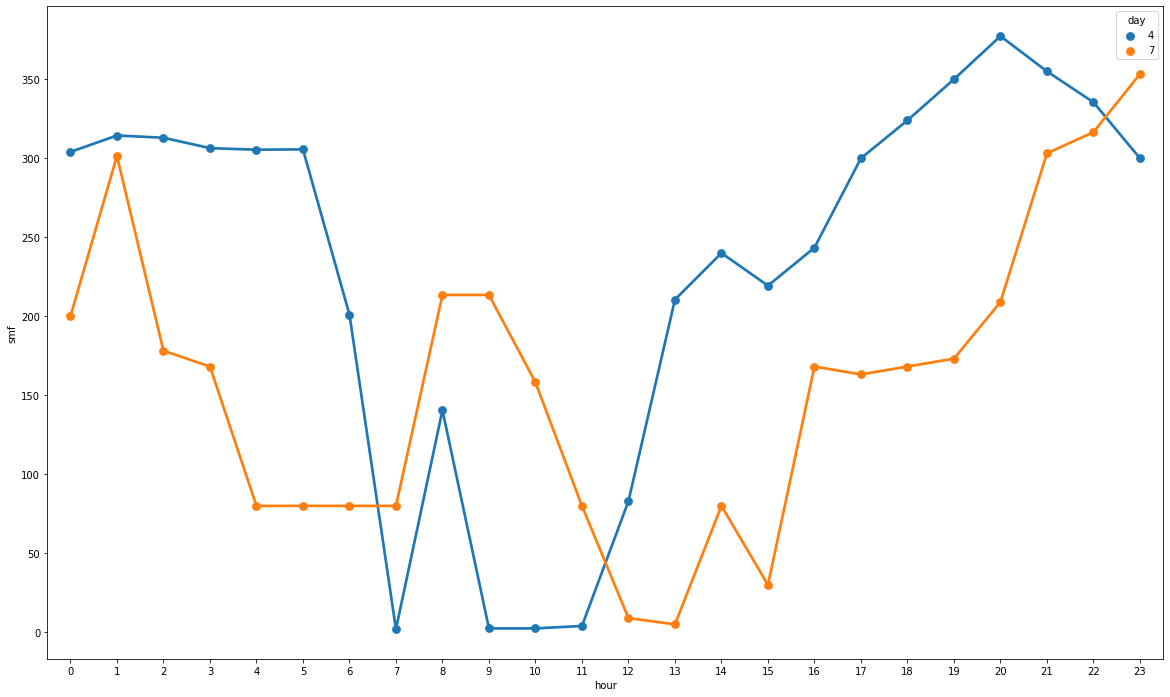

In [ ]:
plt.figure(figsize=(20,12))
sns.pointplot(data=df[(df['day']==4) | (df['day']==7)], x='hour', y='smf',hue='day')

#Time Series shown above have sequences that are similar with a phase difference, Euclidian distance is expected to underperform in such circumstance and Dynamic Time Warping scheme should be used instead 

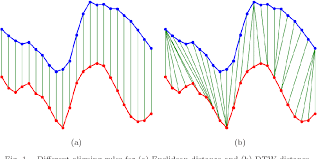

https://www.semanticscholar.org/paper/MODIS-NDVI-time-series-clustering-under-dynamic-Zhang-Tang/3b2c7471bd1a4b2da07571877f7a168f8fca4655/figure/0

#K-means algo is for minimizing variance not arbitrary distances, also it will cluster the series like its any tabular data without capturing patterns in time dimension, So Hierarchical Clustering should be used instead.

In [ ]:
df.head(1)

,time,ptf,smf,netYon,day,hour,dayofweek,smf_ptf_diff,label
0,2021-04-01,234.43,263.43,304.476,1,0,3,29.0,1


In [6]:
#Reshaping data to seperate days
#df2 = df.drop('time',1).values
df2 = df[['ptf','smf','netYon','smf_ptf_diff']].values
df2 = df2.reshape((30,-1,6))

In [19]:
#Computing Distance Matrix with DTW
series_list = df2
for i in range(len(series_list)):
    length = len(series_list[i])
    series_list[i] = series_list[i].reshape((length, series_list.shape[2]))

# Initialize
n_series = len(series_list)
distance_matrix = np.zeros(shape=(n_series, n_series))

# Fill distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = series_list[i]
        y = series_list[j]
        if i != j:
            dist = dtw_distance(x, y)
            distance_matrix[i, j] = dist

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



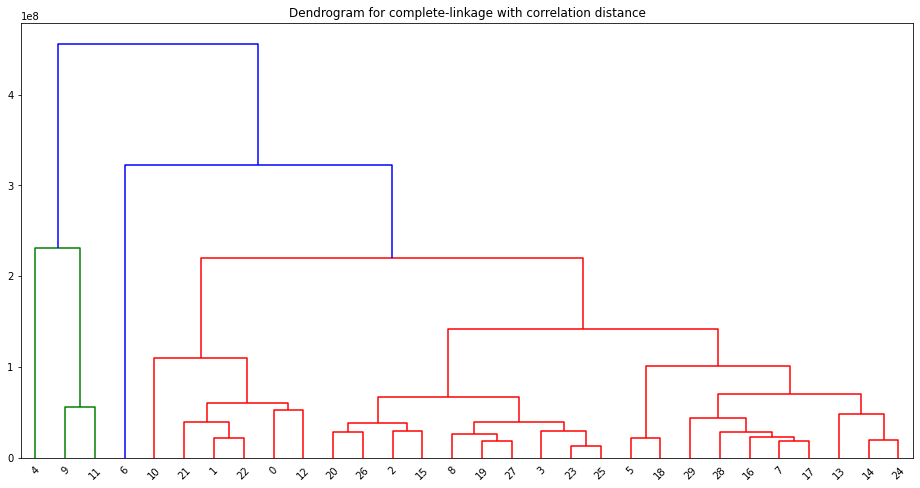

In [34]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    return Z
linkage_matrix = hierarchical_clustering(distance_matrix)

#Silhouette Score is a metric to be optimized for clustering formulated as 
Silhouette Score = (b-a)/max(a,b)


a = average intra-cluster distance i.e the average distance between each point within a cluster.

b = average inter-cluster distance i.e the average distance between all clusters.
#It offers a well defined optimal point unlike the methods like the elbow method which uses MSE and gradually drops

For n_clusters = 2 The average silhouette_score is : 0.6617164713198921
For n_clusters = 3 The average silhouette_score is : 0.5218353382966792
For n_clusters = 4 The average silhouette_score is : 0.5092859043073069
For n_clusters = 5 The average silhouette_score is : 0.3804356322822475
For n_clusters = 6 The average silhouette_score is : 0.31213197362142164
For n_clusters = 7 The average silhouette_score is : 0.2505101861391787
For n_clusters = 8 The average silhouette_score is : 0.2974615996397656
For n_clusters = 9 The average silhouette_score is : 0.2823397748282173


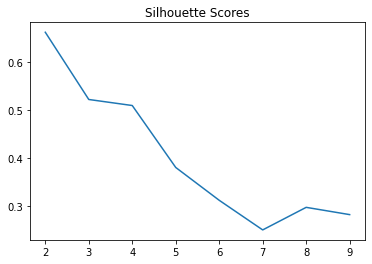

In [21]:
savg = []
for i in np.arange(2,10):
  cluster_labels = fcluster(linkage_matrix, i, criterion='maxclust')
  df_pca['label'] = df['day'].apply(lambda x:cluster_labels[x-1])
  df_pca['day'] = df['day']
  df['label'] = df_pca['label']
  silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric="precomputed")
  print("For n_clusters =", i,"The average silhouette_score is :", silhouette_avg)
  savg.append(silhouette_avg)
plt.title('Silhouette Scores')
plt.plot(np.arange(2,10),savg)

Dendogram suggests 3 clusters, but assigning only one series to a cluster which is not significantly different due to inspection, silhouette method suggests n_clusters = 2 which is convenient.

Setting n_clusters = 2

In [33]:
cluster_labels = fcluster(linkage_matrix, 2, criterion='maxclust')
df_pca['label'] = df['day'].apply(lambda x:cluster_labels[x-1])
df_pca['day'] = df['day']
df['label'] = df_pca['label']
fig = px.scatter_3d(df_pca, x='pc1', y='pc2', z='pc3', color='label')
fig.show()

PLOTTING PTF CLUSTERS 

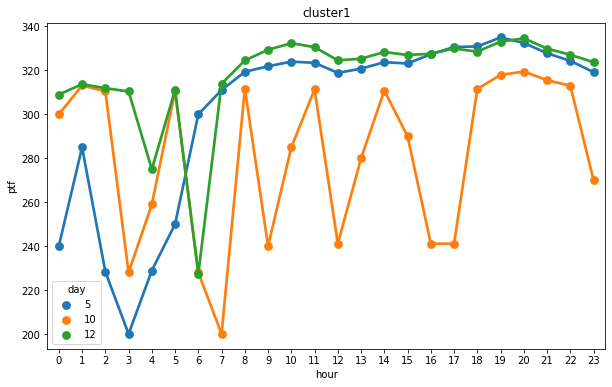

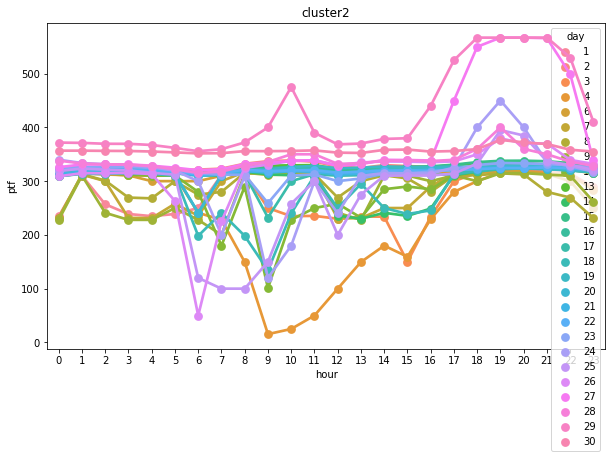

In [35]:
for i in range(df['label'].nunique()):
  plt.figure(figsize=(10,6))
  plt.title('cluster'+str(i+1))
  sns.pointplot(data=df[df['label'] == i+1], x='hour', y='ptf',hue='day')

PLOTTING SMF CLUSTERS

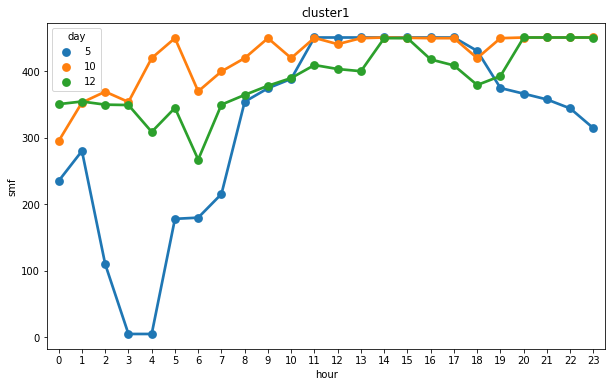

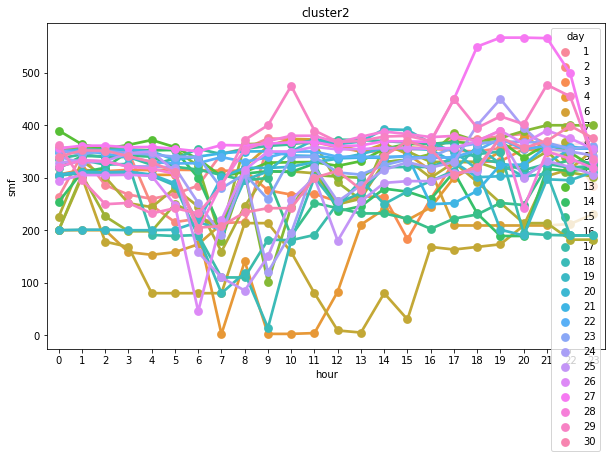

In [36]:
for i in range(df['label'].nunique()):
  plt.figure(figsize=(10,6))
  plt.title('cluster'+str(i+1))
  sns.pointplot(data=df[df['label'] == i+1], x='hour', y='smf',hue='day')

PLOTTING NETYON CLUSTERS

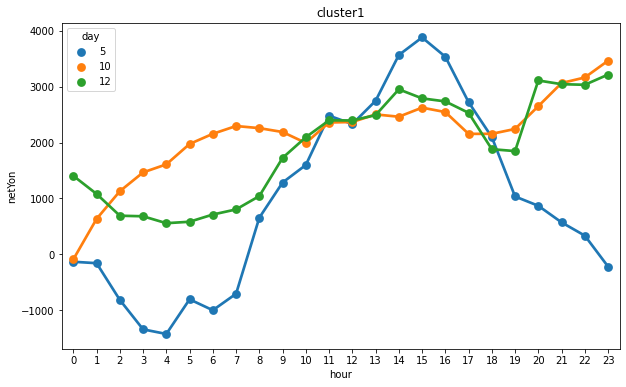

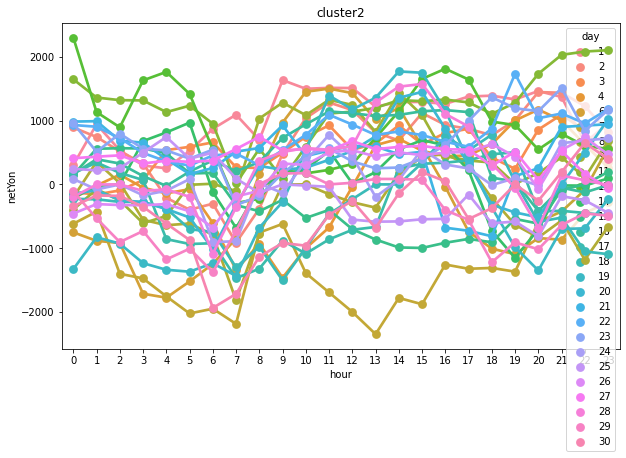

In [37]:
for i in range(df['label'].nunique()):
  plt.figure(figsize=(10,6))
  plt.title('cluster'+str(i+1))
  sns.pointplot(data=df[df['label'] == i+1], x='hour', y='netYon',hue='day')